In [47]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2 as cv
from PIL import Image
import glob
import torchvision
import torchvision.transforms as transforms

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

model = YOLO('runs/segment/train/weights/best.pt')
names = glob.glob('data_base/valid/*/*.png')
predict_params = {"imgsz": 640, "conf": 0.1, "verbose": False, "device": "cpu", "max_det": 1}

mean, std = [0.6927], [0.1174]

size = 128

TRANSFORM = transforms.Compose([transforms.Grayscale(),
                                transforms.Resize([size, size]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

classes = ['DRIVERS_SIDE_1',
     'DRIVERS_SIDE_2',
     'PASSPORT_SIDE_1',
     'PASSPORT_SIDE_2',
     'STS_SIDE_1',
     'STS_SIDE_2']

In [48]:
img_root = names[0]
img_root

'data_base/valid\\DRIVERS_SIDE_1\\v_9906479133-1.png'

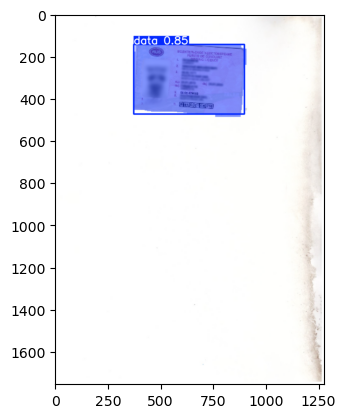

In [49]:
results = model(img_root, **predict_params)
annotated_frame = results[0].plot()
annotated_frame = cv.cvtColor(annotated_frame, cv.COLOR_BGR2RGB)
plt.imshow(annotated_frame)
plt.show()

In [50]:
def make_data(img_root):
    size_max = 1024
    
    results = model(img_root, **predict_params)
    if results[0].masks == None:
        return "image dont seg"
    
    xy_result = results[0].masks.xy[0]

    x_min, x_max, y_min, y_max = 10 ** 5, -1, 10 ** 5, -1
    for x, y in xy_result:
        x_min = min(x_min, x)
        x_max = max(x_max, x)
        y_min = min(y_min, y)
        y_max = max(y_max, y)

    mid = [int((x_min + x_max) / 2), int((y_min + y_max) / 2)]

    xy_result_norm = xy_result.copy()
    xy_result_norm -= mid

    left_up, rigth_up, right_down, left_down = [0, 0], [0, 0], [0, 0], [0, 0]
    for x, y in xy_result_norm:
        if x < 0 and y < 0 and abs(left_up[0]) + abs(left_up[1]) < abs(x) + abs(y):
            left_up = [x, y]
        elif x > 0 and y < 0 and abs(rigth_up[0]) + abs(rigth_up[1]) < abs(x) + abs(y):
            rigth_up = [x, y]
        elif x > 0 and y > 0 and abs(right_down[0]) + abs(right_down[1]) < abs(x) + abs(y):
            right_down = [x, y]
        elif x < 0 and y > 0 and abs(left_down[0]) + abs(left_down[1]) < abs(x) + abs(y):
            left_down = [x, y]
    for i in range(2):
        left_up[i] = int(mid[i] + left_up[i])
        rigth_up[i] = int(mid[i] + rigth_up[i])
        right_down[i] = int(mid[i] + right_down[i])
        left_down[i] = int(mid[i] + left_down[i])

    img = cv.imread(img_root)
    #img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    pts1 = np.float32([left_up, rigth_up, left_down, right_down])
    if x_max - x_min > y_max - y_min:
        pts2 = np.float32([[0, 0], [size_max, 0], [0, int(size_max * 3 / 4)], [size_max, int(size_max * 3 / 4)]])
        M = cv.getPerspectiveTransform(pts1, pts2)
        dst = cv.warpPerspective(img, M, (size_max, int(size_max * 3 / 4)))
    else:
        pts2 = np.float32([[0, 0], [int(size_max * 3 / 4), 0], [0, size_max], [int(size_max * 3 / 4), size_max]])
        M = cv.getPerspectiveTransform(pts1, pts2)
        dst = cv.warpPerspective(img, M, (int(size_max * 3 / 4), size_max))

    cv.imwrite("need_predict/X/image_after_segment.png", dst)

In [51]:
make_data(img_root)

In [52]:
model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(in_features=512, out_features=6, bias=True)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [53]:
model.load_state_dict(torch.load("model_class", weights_only=True, map_location=torch.device('cpu')))
print("Кол-во параметров = ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Кол-во параметров =  11173318


In [54]:
img = torchvision.datasets.ImageFolder("need_predict", TRANSFORM)
img = img[0][0]
img = img.reshape(1, 1, 128, 128)

In [55]:
img.min()

tensor(-3.6289)

In [56]:
with torch.no_grad():
    print(model(img))
    label = model(img).argmax(dim=1).item()
classes[label]

tensor([[ 4.9091e+00, -6.6003e+00, -4.5772e-02, -2.2252e-03, -7.3916e+00, -1.7884e+00]])


'DRIVERS_SIDE_1'

SOLELY 90 66
99 06 479133


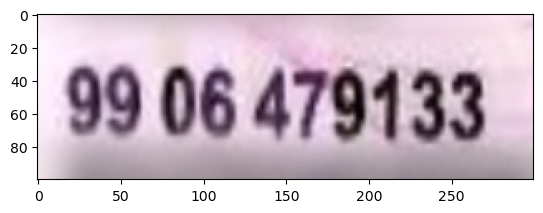

In [60]:
model = YOLO('runs/detect/train2/weights/best.pt')
img_root = "need_predict/X/image_after_segment.png"

if label != 3:
    results = model(img_root, **predict_params)
    x1, y1, x2, y2 = results[0].boxes.xyxy[0]
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    
    img = cv.imread(img_root)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = img[y1:y2, x1:x2]
    
    if y2 - y1 > x2 - x1:
        if label == 2:
            img = cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE)
        else:
            img = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)

            img_document = cv.imread(img_root)
            img_document = cv.rotate(img_document, cv.ROTATE_90_CLOCKWISE)
            cv.imwrite(img_root, img_document)
    elif label == 2:
        img_document = cv.imread(img_root)
        img_document = cv.rotate(img_document, cv.ROTATE_90_CLOCKWISE)
        cv.imwrite(img_root, img_document)
    
    img = cv.resize(img, (300, 100))
    cv.imwrite("need_predict/X/text.jpg", img)
    plt.imshow(img)
    
    img = Image.open("need_predict/X/text.jpg")
    text = pytesseract.image_to_string(img)
    text = text[:12]

    img = cv.imread("need_predict/X/text.jpg")
    print(text)
    
    need_predict = False
    
    for item in text:
        if not ("0" <= item <= "9" or item == " "):
            img = cv.rotate(img, cv.ROTATE_180)

            img_document = cv.imread(img_root)
            img_document = cv.rotate(img_document, cv.ROTATE_180)
            cv.imwrite(img_root, img_document)

            need_predict = True
            break

    cv.imwrite("need_predict/X/text.jpg", img)
    plt.imshow(img)
    
    if need_predict:
        img = Image.open("need_predict/X/text.jpg")
        text = pytesseract.image_to_string(img)
        text = text[:12]
        print(text)